In [1]:
using PyPlot
using DSP
using QuadGK

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [2]:
const t = 0.5
U = 5.9
T = 0.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-16.0,16.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.50;
kB = 8.617333262145e-5;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("cubic",t,ω);

  0.519366 seconds (1.74 M allocations: 123.460 MiB, 6.99% gc time)


In [7]:
function ipt_solver(Aw, nf, U)
    Ap = Aw[:,1] .* nf
    Am = Aw[:,2] .* nf
    App = conv_same(Ap,Ap)
    Appp = conv_same(Am, App)
    return -π .* U^2 .* (Appp + Appp[end:-1:1])

    return -π .* U^2 .* (AAB + BBA)
end

function ipt_selfcons(ω,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        gloc = zeros(ComplexF64,nω,2)
        g0 = zeros(ComplexF64,nω,2)
        isi = zeros(Float64,nω,2)
        hsi = zeros(Float64,nω,2)
        A0 = zeros(Float64,nω,2)
        Σ2 = zeros(ComplexF64,nω,2)

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.9 -0.9]
    
        for i = 1:nω
            ζ_up = zeta(ω[i] - Σ1[1],η)
            ζ_down = zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            @fastmath @inbounds for i in 1:2
                ncalc[i] = -1/π .* trapz(ω,imag(gloc[:,i]) .* nf)
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:2 A0[:,i] = -imag(g0[:,i]) ./ π end
        
            for i = 1:2
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ2,magnet

end;

In [194]:
T = 150.
Us = [1.0, 1.5, 2.0, 2.5, 4.0, 4.5]
Us = convert(Array{Float64},Us)

glocU = zeros(ComplexF64,nω,2,length(Us))
Σ2U = zeros(ComplexF64,nω,2,length(Us))
magnetU = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    glocU[:,:,iU],Σ2U[:,:,iU],magnetU[iU] = ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol);
end

Convergent is achieved for U = 1.0, and T = 150.0 K
Convergent is achieved for U = 2.0, and T = 150.0 K
Convergent is achieved for U = 2.5, and T = 150.0 K
Convergent is achieved for U = 4.0, and T = 150.0 K
Convergent is achieved for U = 4.5, and T = 150.0 K


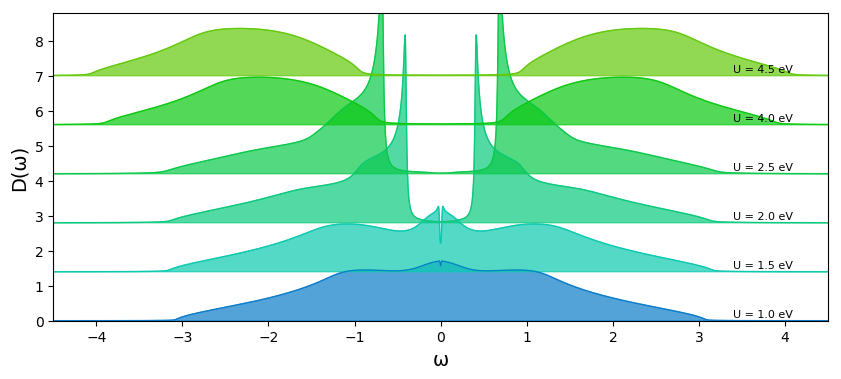

In [343]:
plt.figure(figsize=(10,4))
color = ["#0A7CC9","#0AC9AF","#0AC97C","#0AC94A","#0AC910","#63C90A"]
dashtype = ["-","-","--","-.",":"]
for (iU,U) in enumerate(Us)
    plt.plot(ω,-imag(sum(glocU[:,:,iU],dims=2)) .+ 1.4*(iU - 1),color=color[iU],linewidth=0.8)
    plt.text(3.4,(iU-1)* 1.4 + 0.1,"U = $U eV",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocU[:,:,iU],dims=2)).+ (iU-1)*1.4),(iU-1)*1.4,alpha=0.7,color=color[iU])
end
plt.xlim(-4.5,4.5)
plt.ylim(0,8.8)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolUDOS_IPT_AF.pdf",format="pdf")

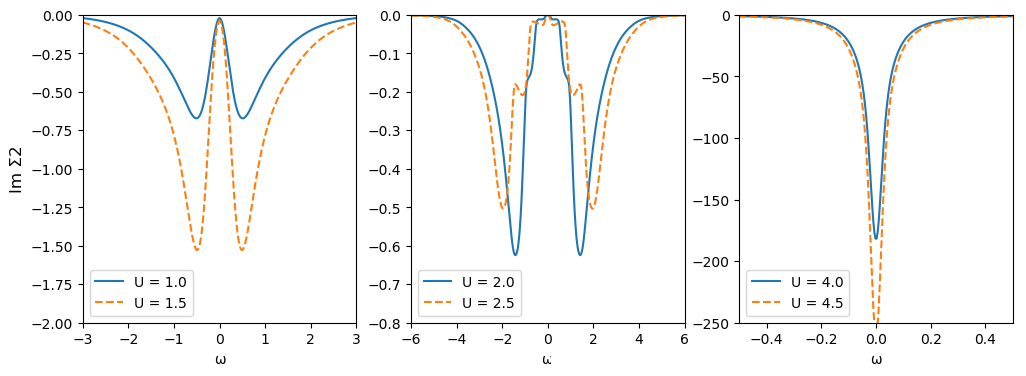

In [344]:
dashtype = ["-","--",":","-.","--",":"]
Us = [1.0, 1.5, 2.0, 2.5, 4.0, 4.5]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
for iU in 1:2
    plt.plot(ω,imag(sum(Σ2U[:,:,iU],dims=2)),dashtype[iU],label="U = $(Us[iU])")
end
plt.ylim(-2,0)
plt.xlim(-3,3)
plt.ylabel("Im Σ2",fontsize=12)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,3,2)
for iU in 3:4
    plt.plot(ω,imag(sum(Σ2U[:,:,iU],dims=2)),dashtype[iU-2],label="U = $(Us[iU])")
end
plt.ylim(-0.8,0)
plt.xlim(-6,6)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,3,3)
for iU in 5:6
    plt.plot(ω,imag(sum(Σ2U[:,:,iU],dims=2)),dashtype[iU-4],label="U = $(Us[iU])")
end
plt.ylim(-250,0)
plt.xlim(-0.5,0.5)
plt.xlabel("ω")
plt.legend()

plt.show()
plt.savefig("evolUΣ2_IPT_AF.pdf",format="pdf")

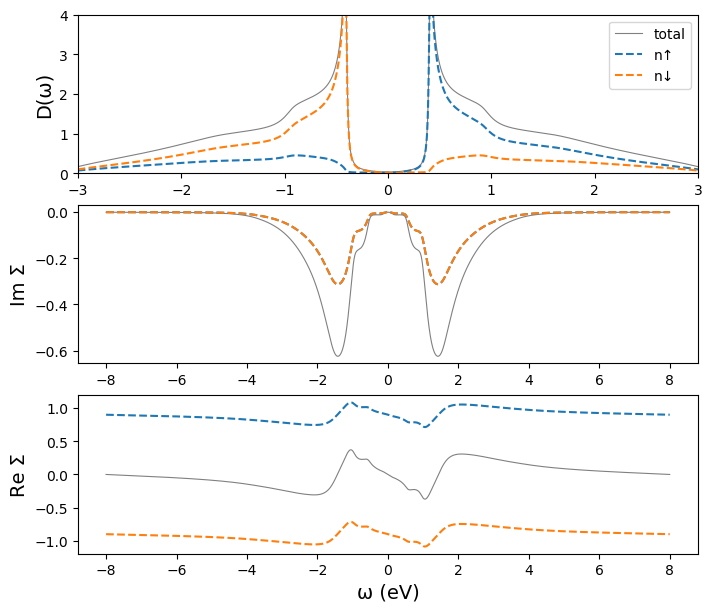

In [345]:
Σ1 = U * magnetU[3]

plt.figure(figsize=(8,7)
)
plt.subplot(3,1,1)
plt.plot(ω,-imag(sum(glocU[:,:,3],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,-imag(glocU[:,1,3]),"--",label="n↑")
plt.plot(ω,-imag(glocU[:,2,3]),"--",label="n↓")
plt.xlim(-3,3)
plt.ylim(0,4)
plt.ylabel("D(ω)",fontsize=14)
plt.legend()

plt.subplot(3,1,2)
plt.plot(ω,imag(sum(Σ2U[:,:,3],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,imag(Σ2U[:,1,3]),"--",label="total")
plt.plot(ω,imag(Σ2U[:,2,3]),"--",label="total")
plt.ylabel("Im Σ",fontsize=14)

plt.subplot(3,1,3)
plt.plot(ω,real(sum(Σ2U[:,:,3],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,Σ1 .+ real(Σ2U[:,1,3]),"--",label="total")
plt.plot(ω,-Σ1 .+ real(Σ2U[:,2,3]),"--",label="total")
plt.xlabel("ω (eV)",fontsize=14)
plt.ylabel("Re Σ",fontsize=14)

plt.show()
plt.savefig("dosupdown_IPT_AF.pdf",format="pdf")

In [218]:
U = 1.8
Ts = [200., 250., 300., 400., 600., 800., 1000.,]
Ts = convert(Array{Float64},Ts)

glocT = zeros(ComplexF64,nω,2,length(Ts))
Σ2T = zeros(ComplexF64,nω,2,length(Ts))
magnetT = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    glocT[:,:,iT],Σ2T[:,:,iT],magnetT[iT] = ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol);
end

Convergent is achieved for U = 1.8, and T = 200.0 K
Convergent is achieved for U = 1.8, and T = 250.0 K
Convergent is achieved for U = 1.8, and T = 300.0 K
Convergent is achieved for U = 1.8, and T = 400.0 K
Convergent is achieved for U = 1.8, and T = 600.0 K
Convergent is achieved for U = 1.8, and T = 800.0 K
Convergent is achieved for U = 1.8, and T = 1000.0 K


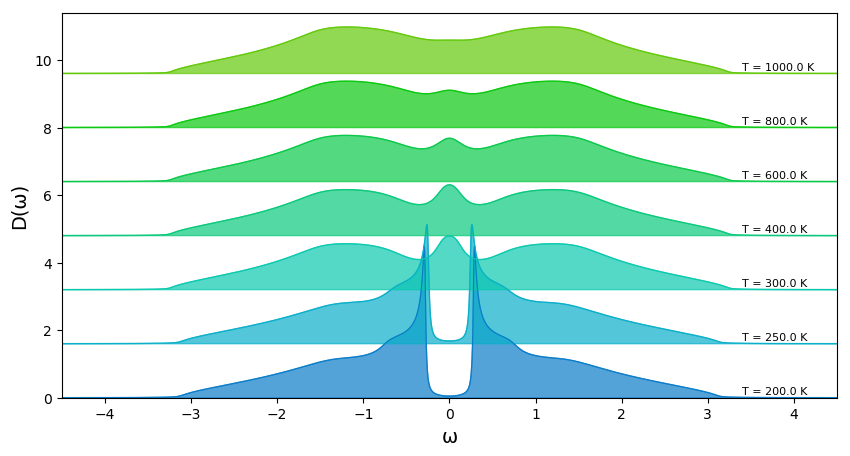

In [346]:
plt.figure(figsize=(10,5))
color = ["#0A7CC9","#0AAFC9","#0AC9AF","#0AC97C","#0AC94A","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iT,T) in enumerate(Ts)
    plt.plot(ω,-imag(sum(glocT[:,:,iT],dims=2)) .+ 1.6*(iT - 1),color=color[iT],linewidth=0.8)
    plt.text(3.4,(iT-1)*1.6 + 0.1,"T = $T K",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocT[:,:,iT],dims=2)).+ (iT-1)*1.6),(iT-1)*1.6,alpha=0.7,color=color[iT])
end
plt.xlim(-4.5,4.5)
plt.ylim(0,11.4)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolTDOS_IPT_AF.pdf",format="pdf")

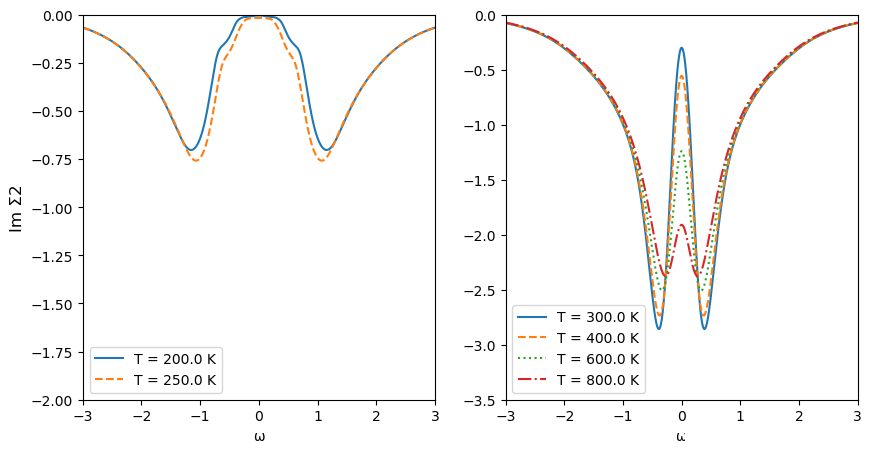

In [347]:
dashtype = ["-","--",":","-.","--",":"]
Ts = [200., 250., 300., 400., 600., 800., 1000.,]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for iT in 1:2
    plt.plot(ω,imag(sum(Σ2T[:,:,iT],dims=2)),dashtype[iT],label="T = $(Ts[iT]) K")
end
plt.ylim(-2,0)
plt.xlim(-3,3)
plt.ylabel("Im Σ2",fontsize=12)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,2,2)
for iT in 3:6
    plt.plot(ω,imag(sum(Σ2T[:,:,iT],dims=2)),dashtype[iT-2],label="T = $(Ts[iT]) K")
end
plt.ylim(-3.5,0)
plt.xlim(-3,3)
plt.xlabel("ω")
plt.legend()

plt.show()
plt.savefig("evolTΣ2_IPT_AF.pdf",format="pdf")

In [8]:
T = 100.

Us = range(0.8,length=20,step=0.3)
Us = convert(Array{Float64},Us)

magnetUs = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    _,_,magnetUs[iU] = ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol);
end

Convergent is achieved for U = 0.8, and T = 100.0 K
Convergent is achieved for U = 1.1, and T = 100.0 K
Convergent is achieved for U = 1.4, and T = 100.0 K
Convergent is achieved for U = 1.7, and T = 100.0 K
Convergent is achieved for U = 2.0, and T = 100.0 K
Convergent is achieved for U = 2.3, and T = 100.0 K
Convergent is achieved for U = 2.6, and T = 100.0 K
Convergent is achieved for U = 2.9, and T = 100.0 K
Convergent is achieved for U = 3.2, and T = 100.0 K
Convergent is achieved for U = 3.5, and T = 100.0 K
Convergent is achieved for U = 3.8, and T = 100.0 K
Convergent is achieved for U = 4.1, and T = 100.0 K
Convergent is achieved for U = 4.4, and T = 100.0 K
Convergent is achieved for U = 4.7, and T = 100.0 K
Convergent is achieved for U = 5.0, and T = 100.0 K
Convergent is achieved for U = 5.3, and T = 100.0 K
Convergent is achieved for U = 5.6, and T = 100.0 K
Convergent is achieved for U = 5.9, and T = 100.0 K
Convergent is achieved for U = 6.2, and T = 100.0 K
Convergent i

In [9]:
U = 2.0

Ts = range(0.0,length=20,stop = 500.)
Ts = convert(Array{Float64},Ts)

glocTs = zeros(ComplexF64,nω,2,length(Ts))
magnetTs = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    _,_,magnetTs[iT] = ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol);
end

Convergent is achieved for U = 2.0, and T = 0.0 K
Convergent is achieved for U = 2.0, and T = 26.31578947368421 K
Convergent is achieved for U = 2.0, and T = 52.63157894736842 K
Convergent is achieved for U = 2.0, and T = 78.94736842105263 K
Convergent is achieved for U = 2.0, and T = 105.26315789473684 K
Convergent is achieved for U = 2.0, and T = 131.57894736842104 K
Convergent is achieved for U = 2.0, and T = 157.89473684210526 K
Convergent is achieved for U = 2.0, and T = 184.21052631578948 K
Convergent is achieved for U = 2.0, and T = 210.52631578947367 K
Convergent is achieved for U = 2.0, and T = 236.8421052631579 K
Convergent is achieved for U = 2.0, and T = 263.1578947368421 K
Convergent is achieved for U = 2.0, and T = 289.4736842105263 K
Convergent is achieved for U = 2.0, and T = 315.7894736842105 K
Convergent is achieved for U = 2.0, and T = 342.10526315789474 K
Convergent is achieved for U = 2.0, and T = 368.42105263157896 K
Convergent is achieved for U = 2.0, and T = 394

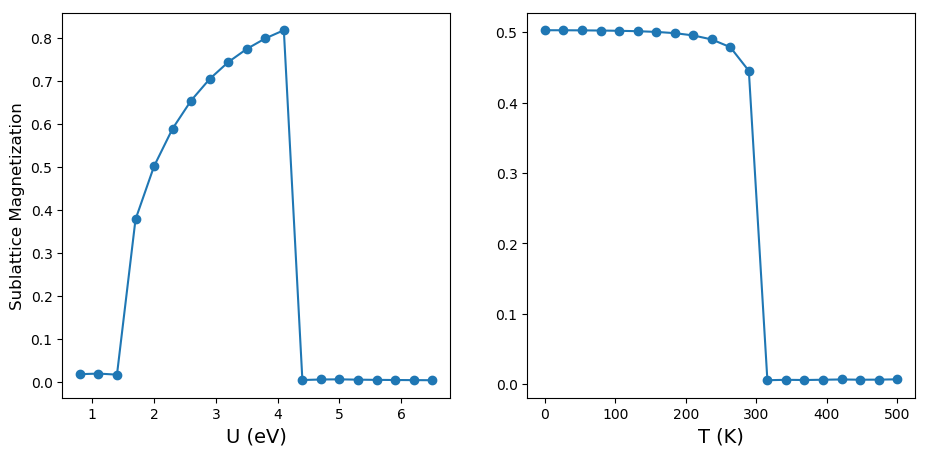

In [10]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(Us,magnetUs,"-o")
plt.ylabel("Sublattice Magnetization",fontsize=12)
plt.xlabel("U (eV)",fontsize=14)

plt.subplot(1,2,2)
plt.plot(Ts,magnetTs,"-o")
plt.xlabel("T (K)",fontsize=14)

plt.show()
plt.savefig("magnetization_IPT_AF.pdf",format="pdf")